# Pitch Quality Grouped

# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [Fastball](#Fastball-Analysis)
    - [Fastball xQual](#Fastball-Leaders)
    - [Fastball HB & VB](#Fastball-HB-&-VB)
- [Breaking Ball Analysis](#Breaking-Ball-Analysis)
    - [Breaking Ball xQual](#Breaking-Ball-Leaders)
    - [Breaking Ball HB & VB](#Breaking-Ball-HB-&-VB)
- [Off-Speed Analysis](#Off-Speed-Analysis)
    - [Off-Speed xQual](#Off-Speed-Leaders)
    - [Off-Speed HB & VB](#Off-Speed-HB-&-VB)

# Imports

In [59]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [60]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv_grouped.shape)
xrv_grouped.head()

(705396, 20)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,FF_count,SI_count,FC_count,xRV,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Gsellman, Robert",R,SI,94.3,1982.0,16.20,10.56,1.20,6.05,6.5,-0.202647,0.0,1.0,0.0,-0.150571,0.0,0.0,0.0,0.0,0.0
1,"Gsellman, Robert",R,SI,94.3,1930.0,18.24,5.88,1.29,6.02,6.4,-0.038875,0.0,1.0,0.0,-0.044392,0.0,0.0,0.0,0.0,0.0
2,"Gsellman, Robert",R,SI,94.2,2102.0,17.04,6.36,1.41,5.88,6.4,-0.028122,0.0,1.0,0.0,-0.034400,0.0,0.0,0.0,0.0,0.0
3,"Gsellman, Robert",R,SI,94.1,2033.0,15.36,4.32,1.31,5.96,6.4,-0.111663,0.0,1.0,0.0,-0.031679,0.0,0.0,0.0,0.0,0.0
4,"Gsellman, Robert",R,SI,93.6,2019.0,15.48,6.96,1.42,5.89,6.5,-0.111663,0.0,1.0,0.0,-0.061563,0.0,0.0,0.0,0.0,0.0


In [61]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,HB,VB,arm_angle,slot,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.6,17.2,43.3,2.0,6.2,3.6,1.7,3.4,1.6
1,"Abreu, Albert",R,FF,103.0,97.8,11.7,15.4,40.8,3.0,6.4,-2.0,-1.9,-2.5,-2.4
2,"Abreu, Bryan",R,FF,310.0,95.7,8.0,17.1,28.7,1.0,6.3,-3.4,-1.1,-6.4,-2.1
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.2,15.1,31.0,1.0,5.8,1.3,1.5,1.2,1.3
4,"Adam, Jason",R,FF,125.0,93.8,7.0,16.8,34.5,1.0,6.7,1.5,1.2,-1.9,-1.5


# Preprocessing

In [62]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

#ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
#fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
#si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
#sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
#cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
#ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']

fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'FC', 'SI'])]
bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'CU', 'KC'])]
os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [63]:
#features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
#                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
#                 'release_extension', 'rv']]
#
#features_vif = features.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features_vif.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
#                   for i in range(len(features_vif.columns))]
#
#print(vif_data.sort_values(by = 'VIF'))

# Analysis

### Run Value for Ball in Play by Events

In [64]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.770147,1.041,1.259,0.572873
1,field_error,0.445453,0.716,0.866,0.298968
2,field_out,-0.271404,0.000,0.000,-0.307975
3,hit_by_pitch,0.359255,0.630,0.762,0.337445
4,home_run,1.385794,1.657,2.003,1.085243
5,single,0.474625,0.746,0.902,0.325699
6,triple,1.062984,1.334,1.613,0.814760
7,walk,0.332291,0.603,0.729,0.419974


### Run Value by Count

In [65]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009615,-0.001082
1,0-1,0.265,-0.018637,-0.009369
2,0-2,0.197,-0.067643,-0.096349
3,1-0,0.356,-0.008226,0.001106
4,1-1,0.300,-0.021004,-0.006760
...,...,...,...,...
7,2-1,0.357,-0.018046,-0.002737
8,2-2,0.269,-0.105299,-0.125028
9,3-0,0.540,0.006415,0.106979
10,3-1,0.477,-0.006323,0.091440


### Average Run Value by Pitch Type

In [66]:
xrv_grouped.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'xRV'].mean()

,pitch_type,rv,xRV
0,SI,-0.013897,-0.011389
1,FF,-0.020096,-0.017627
2,FC,-0.019965,-0.018246
3,SL,-0.033545,-0.032811
4,CU,-0.031498,-0.031279
5,KC,-0.034991,-0.035252
6,CH,-0.026356,-0.025958
7,FS,-0.043639,-0.041130


# Grouped Pitches

## Fastball
4-Seam, Cutter, Sinker

In [67]:
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']

fb_r_avg = fb_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                            'release_pos_z', 'release_extension'].mean()
fb_l_avg = fb_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False, 
                              sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                            'release_pos_z', 'release_extension'].mean()
fb_avg = pd.concat([fb_r_avg, fb_l_avg], ignore_index = True)
fb_avg = fb_avg.round(1)
fb_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SI,R,93.4,2143.9,14.8,9.2,5.7,6.3
1,FF,R,94.1,2283.3,7.1,16.1,5.9,6.4
2,FC,R,89.5,2422.6,-3.0,7.9,5.9,6.3
3,FF,L,92.8,2249.4,-7.5,16.2,6.0,6.3
4,SI,L,92.1,2077.2,-15.0,9.3,5.8,6.3
5,FC,L,86.8,2267.2,1.7,7.9,5.8,6.2


In [68]:
fb[['rv', 'xRV']].describe()

,rv,xRV
count,406250.000000,406250.000000
mean,-0.018415,-0.016023
std,0.228047,0.129509
min,-1.588089,-1.133466
25%,-0.049628,-0.049859
50%,-0.028122,-0.018081
75%,0.023160,0.014607
max,3.081886,1.978544


### Fastball xQual Leaders

In [74]:
fb['RV/100'] = round(((fb['rv'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)
fb['xRV/100'] = round(((fb['xRV'] / (fb['FF_count'] + fb['SI_count'] + fb['FC_count'])) * 100), 2)

cols = list(fb[['rv', 'xRV', 'RV/100', 'xRV/100']])
fb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fb[col_zscore] = ((fb[col] - fb[col].mean()) / fb[col].std(ddof = 0) * -1)

stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                   as_index = False)['FF_count', 'SI_count', 'FC_count', 'rv', 'xRV', 
                                     'rv_zscore', 'xRV_zscore'].sum()

fb = pd.merge(fb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])   
fb['Qual'] = fb['rv_zscore_y'] + 100
fb['xQual'] = fb['xRV_zscore_y'] + 100
fb_r_stats = fb.loc[fb['p_throws'] == 'R']
fb_l_stats = fb.loc[fb['p_throws'] == 'L']
group_stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                         as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                           'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, group_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'FF_count', 'SI_count', 'FC_count',
                                 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

fb_leaders = stats.sort_values(by = ['xQual'], ascending = False)
fb_leaders.head(10)

,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
269,"Cole, Gerrit",R,FF,1397.0,0.0,0.0,97.67,11.99,17.96,-50.63,-3.62,209.21,-61.44,-4.40,401.60
1116,"Ray, Robbie",L,FF,1864.0,0.0,0.0,94.78,-8.18,17.13,-68.18,-3.66,248.47,-66.49,-3.57,382.81
1225,"Scherzer, Max",R,FF,1316.0,0.0,0.0,94.30,10.61,16.03,-47.15,-3.58,200.47,-52.70,-4.00,344.11
1460,"Wheeler, Zack",R,FF,1353.0,0.0,0.0,97.17,7.65,15.91,-52.82,-3.90,222.38,-48.81,-3.61,309.50
1158,"Rogers, Trevor",L,FF,1249.0,0.0,0.0,94.55,-11.07,14.80,-45.25,-3.62,197.58,-46.80,-3.75,306.84
1494,"Woodruff, Brandon",R,FF,940.0,0.0,0.0,96.52,6.35,16.64,-44.81,-4.77,220.60,-41.79,-4.45,306.37
1534,"deGrom, Jacob",R,FF,704.0,0.0,0.0,99.21,9.07,16.45,-33.26,-4.72,189.02,-35.95,-5.11,290.51
1154,"Rodón, Carlos",L,FF,1302.0,0.0,0.0,95.36,-7.94,17.55,-49.64,-3.81,212.52,-44.37,-3.41,281.55
923,"Montas, Frankie",R,FF,877.0,0.0,0.0,96.42,7.00,17.42,-33.39,-3.81,175.60,-36.10,-4.12,270.27
815,"Manaea, Sean",L,SI,0.0,1782.0,0.0,92.14,-13.79,12.28,-54.55,-3.06,195.32,-50.28,-2.82,267.79


In [12]:
fb[['Qual', 'xQual']].describe()

,Qual,xQual
count,406250.000000,406250.000000
mean,108.135061,112.048210
std,40.450615,68.324609
min,-38.549554,-145.190695
25%,83.319741,72.166834
50%,100.516652,100.083091
75%,129.738931,142.411566
max,248.472710,401.597225


### RHP Fastball HB & VB xQual

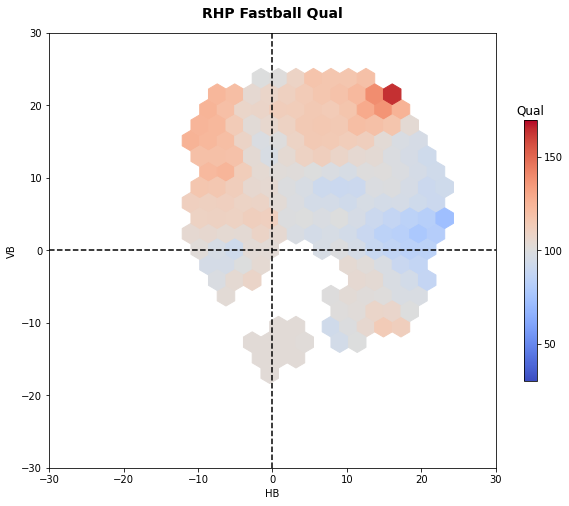

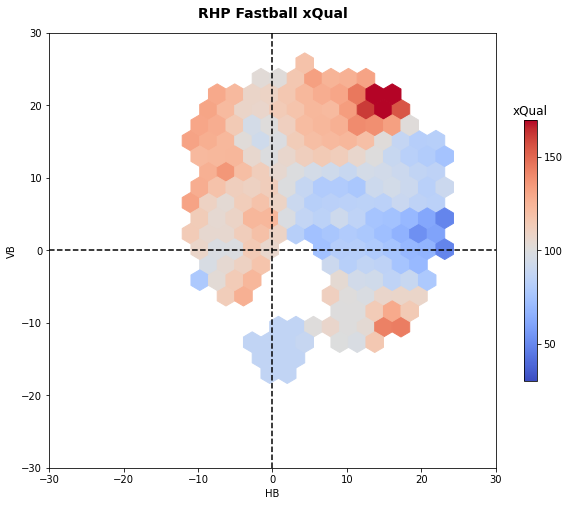

In [13]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_stats['pfx_x'], fb_r_stats['pfx_z'], C = fb_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball HB & VB xQual

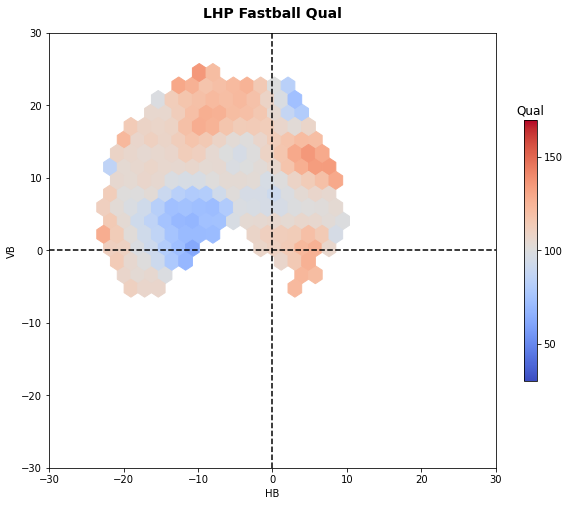

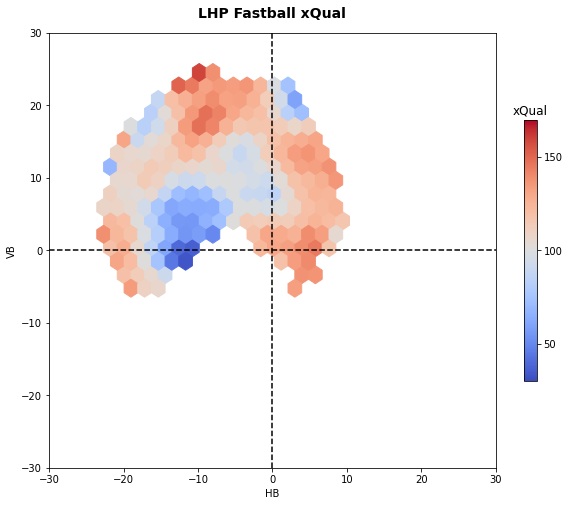

In [14]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_stats['pfx_x'], fb_l_stats['pfx_z'], C = fb_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50, 100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

If we have a negative z-score the corresponding raw score should be less than the mean, and a positive z-score must correspond to a raw score higher than the mean.

## Breaking Ball
Slider, Curveball, Knuckle Curve

In [15]:
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

bb_r_avg = bb_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
bb_l_avg = bb_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
bb_avg = pd.concat([bb_r_avg, bb_l_avg], ignore_index = True)
bb_avg = bb_avg.round(1)
bb_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SL,R,84.9,2438.2,-6.3,1.8,5.8,6.3
1,CU,R,79.2,2538.3,-9.6,-9.3,6.0,6.2
2,KC,R,81.5,2575.8,-8.3,-11.7,5.9,6.3
3,SL,L,83.9,2357.1,5.8,1.5,5.9,6.2
4,CU,L,77.7,2439.9,8.4,-7.5,6.0,6.1
5,KC,L,78.9,2310.0,5.0,-9.0,6.3,6.0


In [16]:
bb[['rv', 'xRV']].describe()

,rv,xRV
count,207975.000000,207975.000000
mean,-0.033062,-0.032538
std,0.224461,0.127781
min,-1.664185,-0.961224
25%,-0.049628,-0.063383
50%,-0.028122,-0.025914
75%,0.023160,0.005658
max,3.066170,1.965608


## Breaking Ball Leaders

In [17]:
bb['RV/100'] = round(((bb['rv'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)
bb['xRV/100'] = round(((bb['xRV'] / (bb['CU_count'] + bb['SL_count'] + bb['KC_count'])) * 100), 2)

cols = list(bb[['rv', 'xRV', 'RV/100', 'xRV/100']])
bb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    bb[col_zscore] = ((bb[col] - bb[col].mean())/ bb[col].std(ddof=0) * -1)

stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['SL_count', 'CU_count', 'KC_count', 
                                         'rv', 'xRV', 'rv_zscore', 'xRV_zscore'].sum()
bb = pd.merge(bb, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
bb['Qual'] = bb['rv_zscore_y'] + 100
bb['xQual'] = bb['xRV_zscore_y'] + 100
bb_r_stats = bb.loc[bb['p_throws'] == 'R']
bb_l_stats = bb.loc[bb['p_throws'] == 'L']

q_stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                                 as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                                   'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'SL_count', 'CU_count', 'KC_count',
                                 'velo', 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

bb_leaders = stats.sort_values(by = ['xQual'], ascending = False)
bb_leaders.head(10)

,player_name,p_throws,pitch_type,SL_count,CU_count,KC_count,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
928,"Rodón, Carlos",L,SL,603.0,0.0,0.0,85.76,8.21,-1.06,-40.56,-6.73,191.89,-44.52,-7.38,294.88
1126,"Urías, Julio",L,CU,0.0,952.0,0.0,81.38,15.78,-0.93,-50.99,-5.35,186.94,-51.04,-5.36,257.02
690,"McClanahan, Shane",L,SL,674.0,0.0,0.0,89.15,3.79,2.03,-33.13,-4.91,148.31,-41.75,-6.19,255.10
761,"Morton, Charlie",R,CU,0.0,1095.0,0.0,80.64,-16.57,-10.06,-59.53,-5.43,203.91,-54.15,-4.95,244.93
1221,"deGrom, Jacob",R,SL,409.0,0.0,0.0,91.57,-4.67,3.46,-29.75,-7.27,172.29,-30.19,-7.38,232.08
766,"Musgrove, Joe",R,SL,815.0,0.0,0.0,84.07,-14.03,-1.56,-43.74,-5.37,174.83,-43.20,-5.30,230.51
935,"Rogers, Tyler",R,SL,479.0,0.0,0.0,71.76,-13.14,13.84,-32.73,-6.83,175.24,-31.90,-6.66,227.68
555,"Kershaw, Clayton",L,SL,859.0,0.0,0.0,87.07,4.71,8.18,-42.26,-4.92,161.73,-43.70,-5.09,223.22
1030,"Smyly, Drew",L,CU,0.0,897.0,0.0,78.86,-2.95,-0.17,-36.06,-4.02,128.52,-44.65,-4.98,221.01
768,"Márquez, Germán",R,KC,0.0,0.0,506.0,85.19,-4.02,-2.97,-33.26,-6.57,173.63,-31.39,-6.20,216.79


In [18]:
bb[['Qual', 'xQual']].describe()

,Qual,xQual
count,207975.000000,207975.000000
mean,105.455172,109.127499
std,27.791856,47.560965
min,30.597978,-12.861929
25%,88.216391,81.543805
50%,101.537877,101.227215
75%,119.989300,131.049459
max,203.909284,294.879741


### RHP Breaking Ball HB & VB

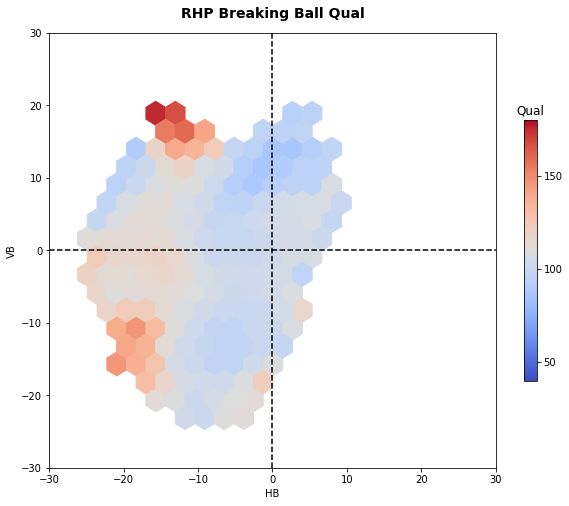

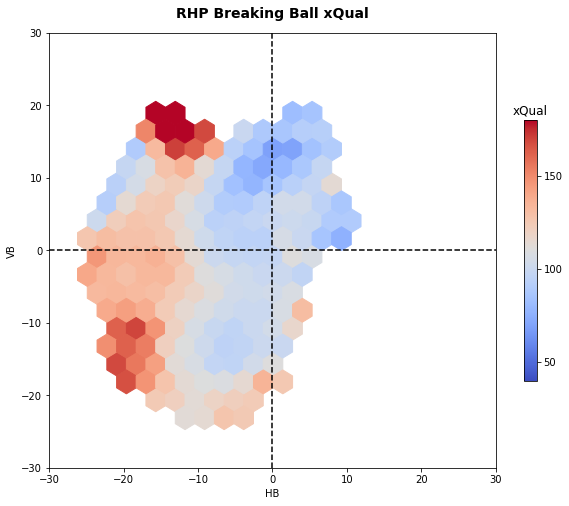

In [19]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball HB & VB

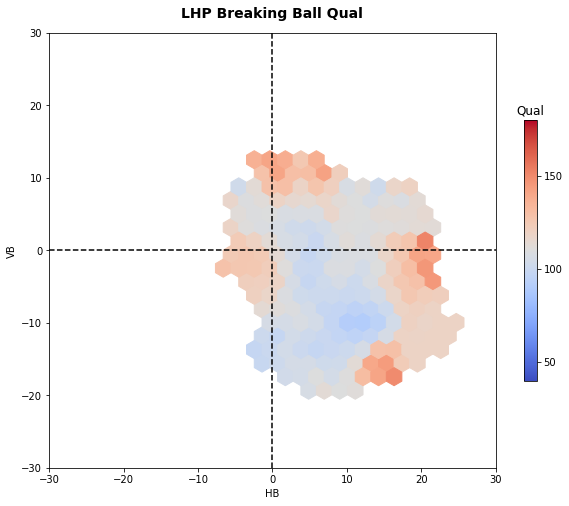

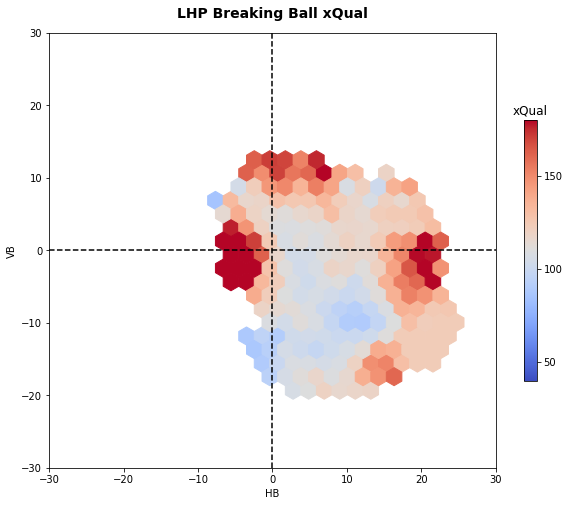

In [20]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed
Changeup, Splitter

In [21]:
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

os_r_avg = os_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
os_l_avg = os_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
os_avg = pd.concat([os_r_avg, os_l_avg], ignore_index = True)
os_avg = os_avg.round(1)
os_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CH,R,85.5,1756.8,13.8,6.3,5.8,6.3
1,FS,R,85.8,1384.0,10.7,3.9,5.9,6.3
2,CH,L,83.6,1737.4,-13.9,7.8,5.8,6.2
3,FS,L,83.8,1039.1,-8.7,4.0,5.8,6.6


In [22]:
os[['rv', 'xRV']].describe()

,rv,xRV
count,91171.000000,91171.000000
mean,-0.028411,-0.027762
std,0.230377,0.130899
min,-1.574855,-0.935269
25%,-0.055418,-0.063668
50%,-0.028122,-0.023441
75%,0.026468,0.010935
max,2.734491,1.852084


### Off-Speed Leaders

In [23]:
os['RV/100'] = round(((os['rv'] / (os['CH_count'] + os['FS_count'])) * 100), 2)
os['xRV/100'] = round(((os['xRV'] / (os['CH_count'] + os['FS_count'])) * 100), 2)

cols = list(os[['rv', 'xRV', 'RV/100', 'xRV/100']])
os[cols]

for col in cols:
    col_zscore = col + '_zscore'
    os[col_zscore] = ((os[col] - os[col].mean()) / os[col].std(ddof=0) * -1)

stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['CH_count', 'FS_count', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
os = pd.merge(os, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
os['Qual'] = os['rv_zscore_y'] + 100
os['xQual'] = os['xRV_zscore_y'] + 100
os_r_stats = os.loc[os['p_throws'] == 'R']
os_l_stats = os.loc[os['p_throws'] == 'L']

q_stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                     as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                       'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'CH_count', 'FS_count', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])

os_leaders = stats.sort_values(by = ['xQual'], ascending = False)
os_leaders.head(10)

,player_name,p_throws,pitch_type,CH_count,FS_count,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
235,"Gausman, Kevin",R,FS,0.0,1044.0,83.60,12.35,2.20,-67.77,-6.49,265.43,-61.15,-5.86,345.73
105,"Castillo, Luis",R,CH,952.0,0.0,88.33,16.77,0.94,-43.83,-4.60,172.86,-48.96,-5.14,272.12
432,"Montas, Frankie",R,FS,0.0,677.0,87.49,11.52,3.82,-39.04,-5.77,185.97,-40.23,-5.94,263.73
403,"Matz, Steven",L,CH,598.0,0.0,85.05,-15.94,3.27,-29.60,-4.95,154.75,-37.68,-6.30,261.04
466,"Ohtani, Shohei",R,FS,0.0,366.0,88.15,4.88,2.41,-33.31,-9.10,199.44,-29.86,-8.16,250.48
485,"Peralta, Wily",R,FS,0.0,352.0,81.27,10.16,6.67,-27.93,-7.93,177.84,-28.89,-8.21,246.06
392,"Manaea, Sean",L,CH,723.0,0.0,84.53,-12.18,6.67,-32.42,-4.48,151.56,-37.60,-5.20,233.88
441,"Morgan, Eli",R,CH,322.0,0.0,74.81,14.74,4.89,-18.72,-5.81,141.55,-23.46,-7.29,210.95
683,"Williams, Devin",R,CH,621.0,0.0,83.72,16.96,-4.16,-29.24,-4.71,150.35,-29.64,-4.77,194.75
612,"Suarez, José",L,CH,449.0,0.0,82.30,-7.79,8.61,-24.32,-5.41,150.19,-23.89,-5.32,187.28


In [24]:
os[['Qual', 'xQual']].describe()

,Qual,xQual
count,91171.000000,91171.000000
mean,108.053679,113.230522
std,30.627166,51.799832
min,44.740873,2.257972
25%,90.909469,83.539988
50%,100.882315,102.699457
75%,119.140569,131.352017
max,265.430519,345.730953


### RHP Off-Speed HB & VB

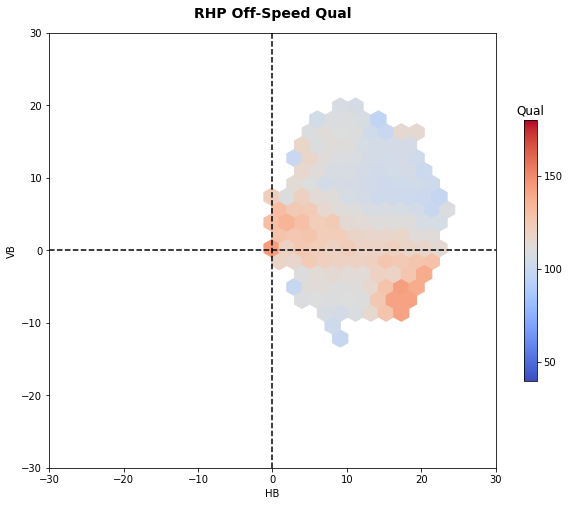

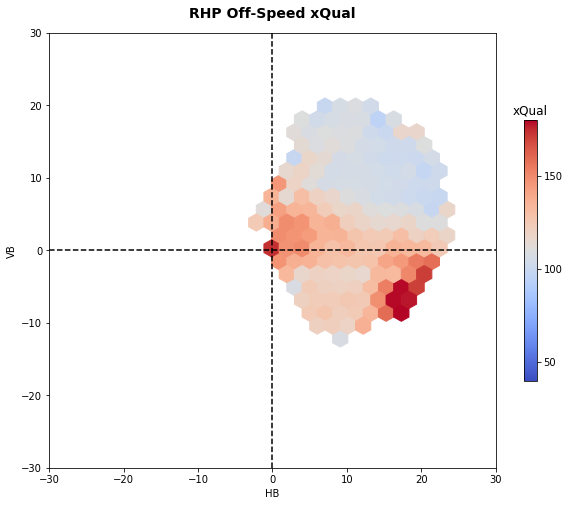

In [25]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed HB & VB

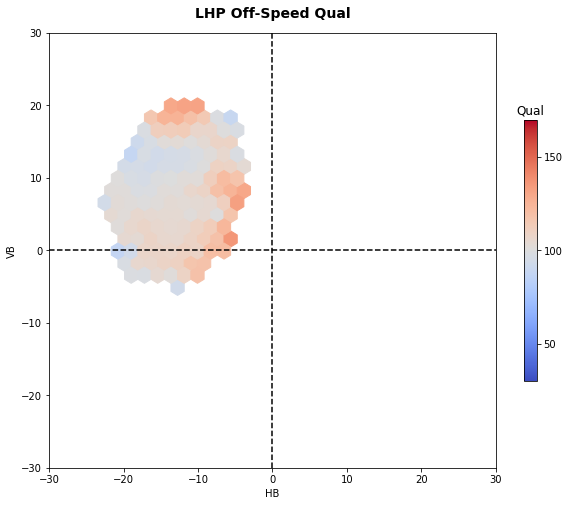

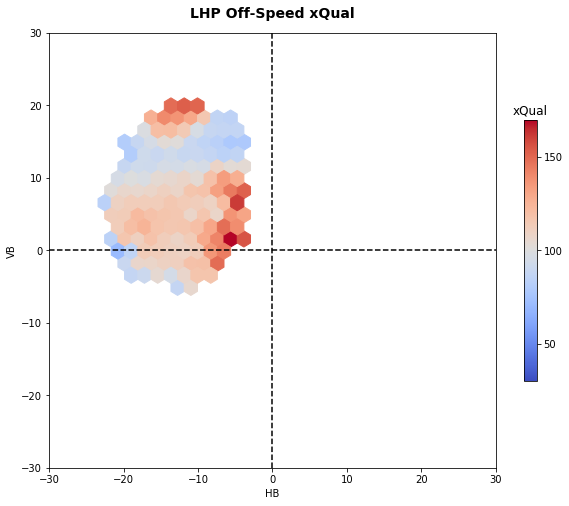

In [26]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed Qual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(30, 170)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Save to CSV

In [30]:
pitch_quality = pd.concat([fb, bb, os], ignore_index = True)
#pitch_quality.to_csv('../data/pitch-quality.csv')

In [32]:
pitch_quality.drop(columns = ['FF_count_x', 'SI_count_x', 'FC_count_x'], inplace = True)

In [33]:
print(pitch_quality.shape)
pitch_quality.head()

(705396, 45)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv_x,xRV_x,CU_count,SL_count,KC_count,CH_count,FS_count,RV/100,xRV/100,rv_zscore_x,xRV_zscore_x,RV/100_zscore,xRV/100_zscore,FF_count_y,SI_count_y,FC_count_y,rv_y,xRV_y,rv_zscore_y,xRV_zscore_y,Qual,xQual,FF_count,SI_count,FC_count,CU_count_x,SL_count_x,KC_count_x,SL_count_y,CU_count_y,KC_count_y,CH_count_x,FS_count_x,CH_count_y,FS_count_y
0,"Gsellman, Robert",R,SI,94.3,1982.0,16.20,10.56,1.20,6.05,6.5,-0.202647,-0.150571,0.0,0.0,0.0,0.0,0.0,-20.26,-15.06,0.807868,1.038909,0.807722,1.039134,0.0,246.0,0.0,-4.775848,-4.551629,1.077574,4.709804,101.077574,104.709804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Gsellman, Robert",R,SI,94.3,1930.0,18.24,5.88,1.29,6.02,6.4,-0.038875,-0.044392,0.0,0.0,0.0,0.0,0.0,-3.89,-4.44,0.089718,0.219051,0.089884,0.219112,0.0,246.0,0.0,-4.775848,-4.551629,1.077574,4.709804,101.077574,104.709804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Gsellman, Robert",R,SI,94.2,2102.0,17.04,6.36,1.41,5.88,6.4,-0.028122,-0.034400,0.0,0.0,0.0,0.0,0.0,-2.81,-3.44,0.042567,0.141900,0.042525,0.141897,0.0,246.0,0.0,-4.775848,-4.551629,1.077574,4.709804,101.077574,104.709804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Gsellman, Robert",R,SI,94.1,2033.0,15.36,4.32,1.31,5.96,6.4,-0.111663,-0.031679,0.0,0.0,0.0,0.0,0.0,-11.17,-3.17,0.408896,0.120888,0.409118,0.121049,0.0,246.0,0.0,-4.775848,-4.551629,1.077574,4.709804,101.077574,104.709804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Gsellman, Robert",R,SI,93.6,2019.0,15.48,6.96,1.42,5.89,6.5,-0.111663,-0.061563,0.0,0.0,0.0,0.0,0.0,-11.17,-6.16,0.408896,0.351639,0.409118,0.351922,0.0,246.0,0.0,-4.775848,-4.551629,1.077574,4.709804,101.077574,104.709804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
